# Lab 3
Lucas Street, 1874989

In [118]:
%%capture
import sys
!{sys.executable} -m pip install --user scipy numpy matplotlib pandas
from multiprocessing import Pool

%matplotlib inline
import matplotlib
import matplotlib.pyplot as plt
matplotlib.rc('font', size=22)
matplotlib.rc('figure', figsize=(18, 10))

import numpy as np
import scipy as sp
import pandas as pd
from scipy import stats
from scipy.optimize import curve_fit

## Problem 1

We have about 100,000 temperature readings from an experiment. The readings are Gaussian-distributed with a mean of 12 K and a standard deviation of 0.4 K.
There are also some erroneous readings, which are added to the Gaussian-distributed data in the code below.

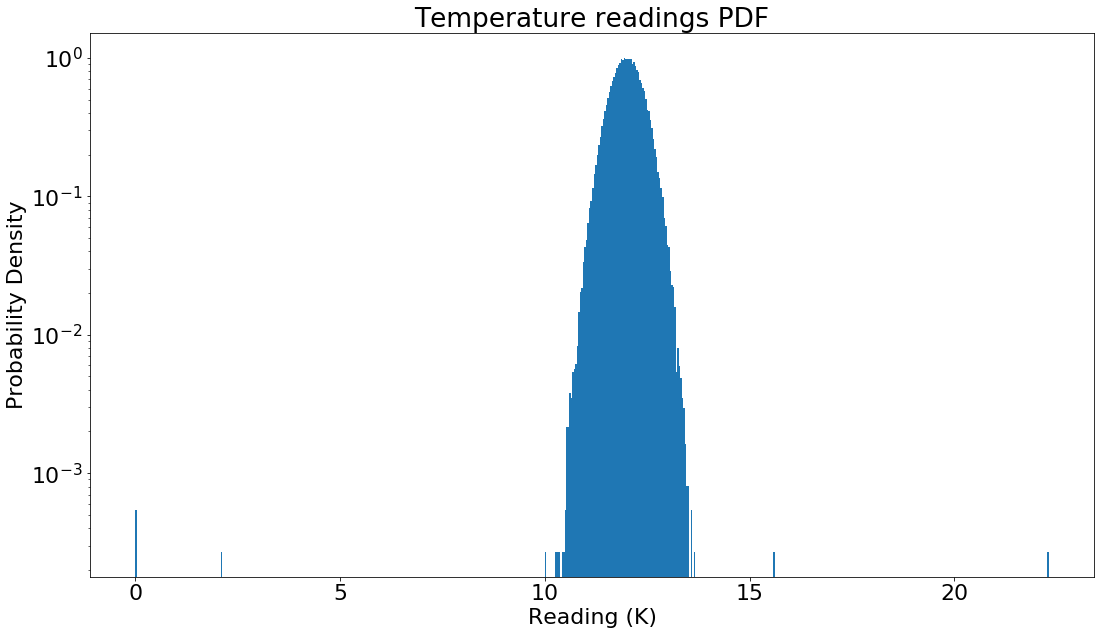

In [119]:
mean, std_dev = 12, 0.4
dist = stats.norm(mean, std_dev)
good_temp_readings = dist.rvs(100_000)
bad_temp_readings = np.array([10., 10.3, 2.1, 0., 0., 15.6, 22.3, 12.7])
temp_readings = np.concatenate((good_temp_readings, bad_temp_readings))
plt.title('Temperature readings PDF')
plt.xlabel('Reading (K)')
plt.ylabel('Probability Density')
plt.hist(temp_readings, bins=600, density=True);
plt.yscale('log');

We want to throw out data points that aren't within some distance 12 K. The question we ask is then: At what value $X\sigma$ away from 12 K does removing readings outside this value retain the most "good" data and discard the most "bad" data?

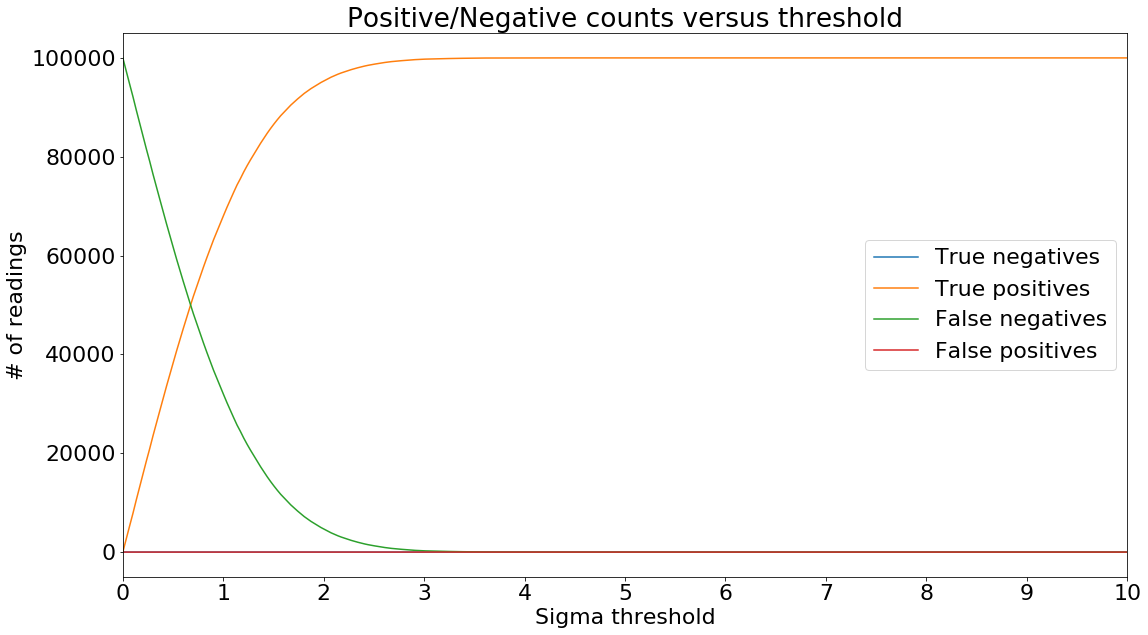

In [120]:
def get_counts(threshold):
    chosen_bad = temp_readings[(temp_readings < mean - threshold*std_dev) | (temp_readings > mean + threshold*std_dev)]
    chosen_good = temp_readings[(temp_readings > mean - threshold*std_dev) & (temp_readings < mean + threshold*std_dev)]
    true_negatives = len(np.intersect1d(chosen_bad, bad_temp_readings))
    true_positives = len(np.intersect1d(chosen_good, good_temp_readings))
    false_negatives = len(np.intersect1d(chosen_bad, good_temp_readings))
    false_positives = len(np.intersect1d(chosen_good, bad_temp_readings))
    return np.array([true_negatives, true_positives, false_negatives, false_positives])

def plot_counts(log_scale=False, draw_result_line=False):
    thresholds = np.linspace(0, 10, 300)
    with Pool() as p:
        results = np.transpose(np.array(p.map(get_counts, thresholds)))

    plt.title('Positive/Negative counts versus threshold')
    plt.xlabel('Sigma threshold')
    plt.ylabel('# of readings')
    plt.plot(thresholds, results[0]) # true negatives
    plt.plot(thresholds, results[1]) # true positives
    plt.plot(thresholds, results[2]) # false negatives
    plt.plot(thresholds, results[3]) # false positives

    if draw_result_line:
        max_true_threshold = thresholds[np.argmax(results[0] + results[1])]
        min_false_threshold = thresholds[np.argmin(results[2] + results[3])]
        print(f"Max true: {max_true_threshold} sigma, Min false: {min_false_threshold} sigma")

        plt.axvline(max_true_threshold, 0, 1, color='k', linestyle='--')
        plt.axvline(min_false_threshold, 0, 1, color='k', linestyle='--')

    if log_scale:
        plt.yscale('log')

    plt.xlim(0, 10)
    plt.xticks(range(0, 11))
    plt.legend(['True negatives', 'True positives', 'False negatives', 'False positives', 'Location of max true values', 'Location of min false values'])
    return results

results = plot_counts()

The relationship between true positives ('good' data that we keep) and false negatives ('good' data that we throw out) seems to be the same relationship between the error function `erf(a*x)` and the function `1 - erf(a*x)`, multiplied by approximately 100,000, plotted below. Let's find a more precise model by curve-fitting and plot the result.

(array([7.04409632e-01, 1.00002854e+05]), array([[9.46863432e-09, 6.48582581e-04],
       [6.48582581e-04, 1.11182203e+02]]))


ValueError: operands could not be broadcast together with shapes (2,100000) (300,) 

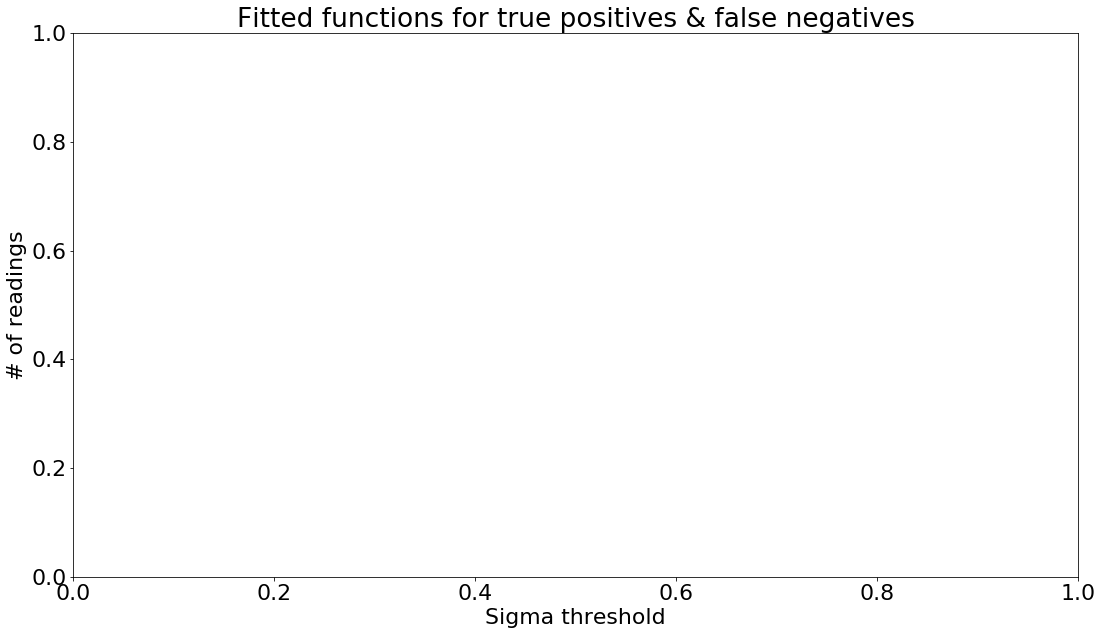

In [123]:
from scipy.special import erf

def obj(x, a, b):
    return b*(1 - erf(a*x))

thresholds = np.linspace(0, 10, 300)

# Find optimal values for a and b
results = curve_fit(obj, thresholds, results[2], [0.7, 1e5])
print(results)
# print(f"a: {a}, b: {b}")


plt.title('Fitted functions for true positives & false negatives')
plt.xlabel('Sigma threshold')
plt.ylabel('# of readings')
plt.plot(thresholds, b*erf(a*thresholds))
plt.plot(thresholds, b*(1 - erf(a*thresholds)))
plt.plot(thresholds, results[1], 'ko', markersize=3)
plt.plot(thresholds, results[2], 'kx', markersize=5)
plt.xlim(0, 10)
plt.legend([f'b*erf(a*x)', 'b*(1 - erf(a*x))', 'True positives', 'False negatives']);

This makes sense, considering that the number of occurences of some value in our background is proportional to the probability of seeing those values, and the error function is closely related to the CDF of a Gaussian distribution: $cdf(x) = \frac{1}{2} \left( 1 + erf\left( \frac{x-\mu}{\sigma\sqrt{2}} \right) \right) $. In this case, the number of true positives or false negatives is predicted fairly well by the equations $TruPos(x) = b*erf(ax)$ and $FalseNeg(x) = b*(1 - erf(ax))$.

Now, to answer the question we asked earlier: what is the _optimal_ value of a threshold that maximizes the amount of 'good' data and minimizes the amount of 'bad' data included in our result?

In [ ]:
plot_counts(log_scale=True, draw_result_line=True);

The location of the dotted line indicates the position at which four quantities are optimized: the amount of good data identified as being good and the amount of bad data identified as being bad are both maximized, and the amount of bad data identified as good and the amount of good data identified as bad are both minimized. (That is, "True" quantities are maximized, "False" quantities are minimized)

Note that there is some bad data getting into our final result (the red curve above). This is unavoidable because further decreasing the amount of false positives getting in would greatly increase the amount of false negatives thrown out of our result (green curve above - good data identified as bad data).

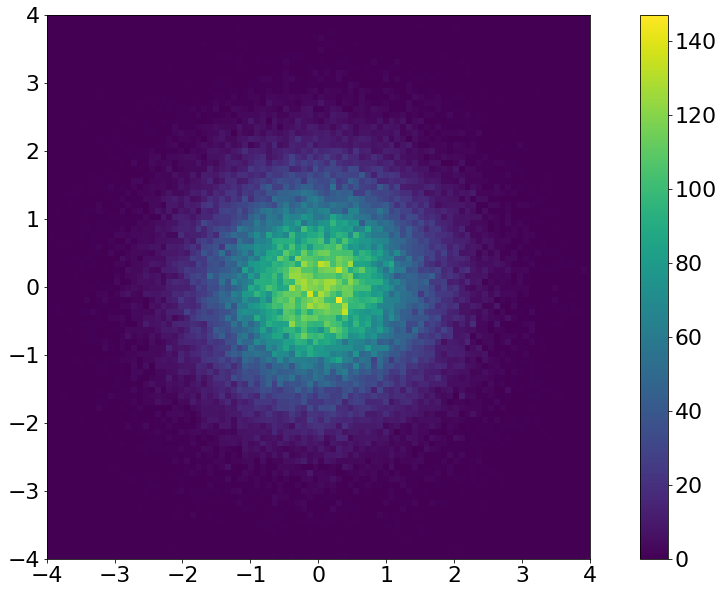

In [124]:
dist = stats.norm(scale=1)
a = dist.rvs((2, 100_000))
plt.hist2d(a[0, :], a[1, :], bins=100)
plt.colorbar()
plt.xlim(-4, 4)
plt.ylim(-4, 4)
plt.xticks(range(-4, 5))
plt.yticks(range(-4, 5))
plt.gca().set_aspect('equal', 'box')

What is the distance away from the origin at which the 2-dimensional Gaussian background produces a signal that has a significance of $5\sigma$?

In [161]:
# Converting to polar coordinates gives r*Gaussian(r; 0, 1), which is a Rayleigh distribution
dist_2d = stats.rayleigh(scale=1)
distance = dist_2d.ppf(dist.cdf(5))

pdf_2d = lambda r: r*np.exp(-r**2 / 2)
value, error = sp.integrate.quad(pdf_2d, distance, np.inf)
print(f"Distance: {distance}")
print(f"Converting back to sigma: {dist.ppf(1 - value)}")

Distance: 5.489079776034238
Converting back to sigma: 4.999999996908459
